In [1]:
!nvidia-smi

Mon Jan 11 11:59:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install gdown
!pip install tensorflow-gpu

     |████████████████████████████████| 394.7MB 44kB/s 


## Import Libraries

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

## Load and Inspect the SENSEX Index Data

In [39]:
df = pd.read_csv('/content/BSE30.csv', parse_dates=['date'], index_col='date')

In [40]:
df.head()

,close
date,
1990-01-01,783.35
1990-01-02,780.01
1990-01-03,763.22
1990-01-04,760.80
1990-01-05,774.58


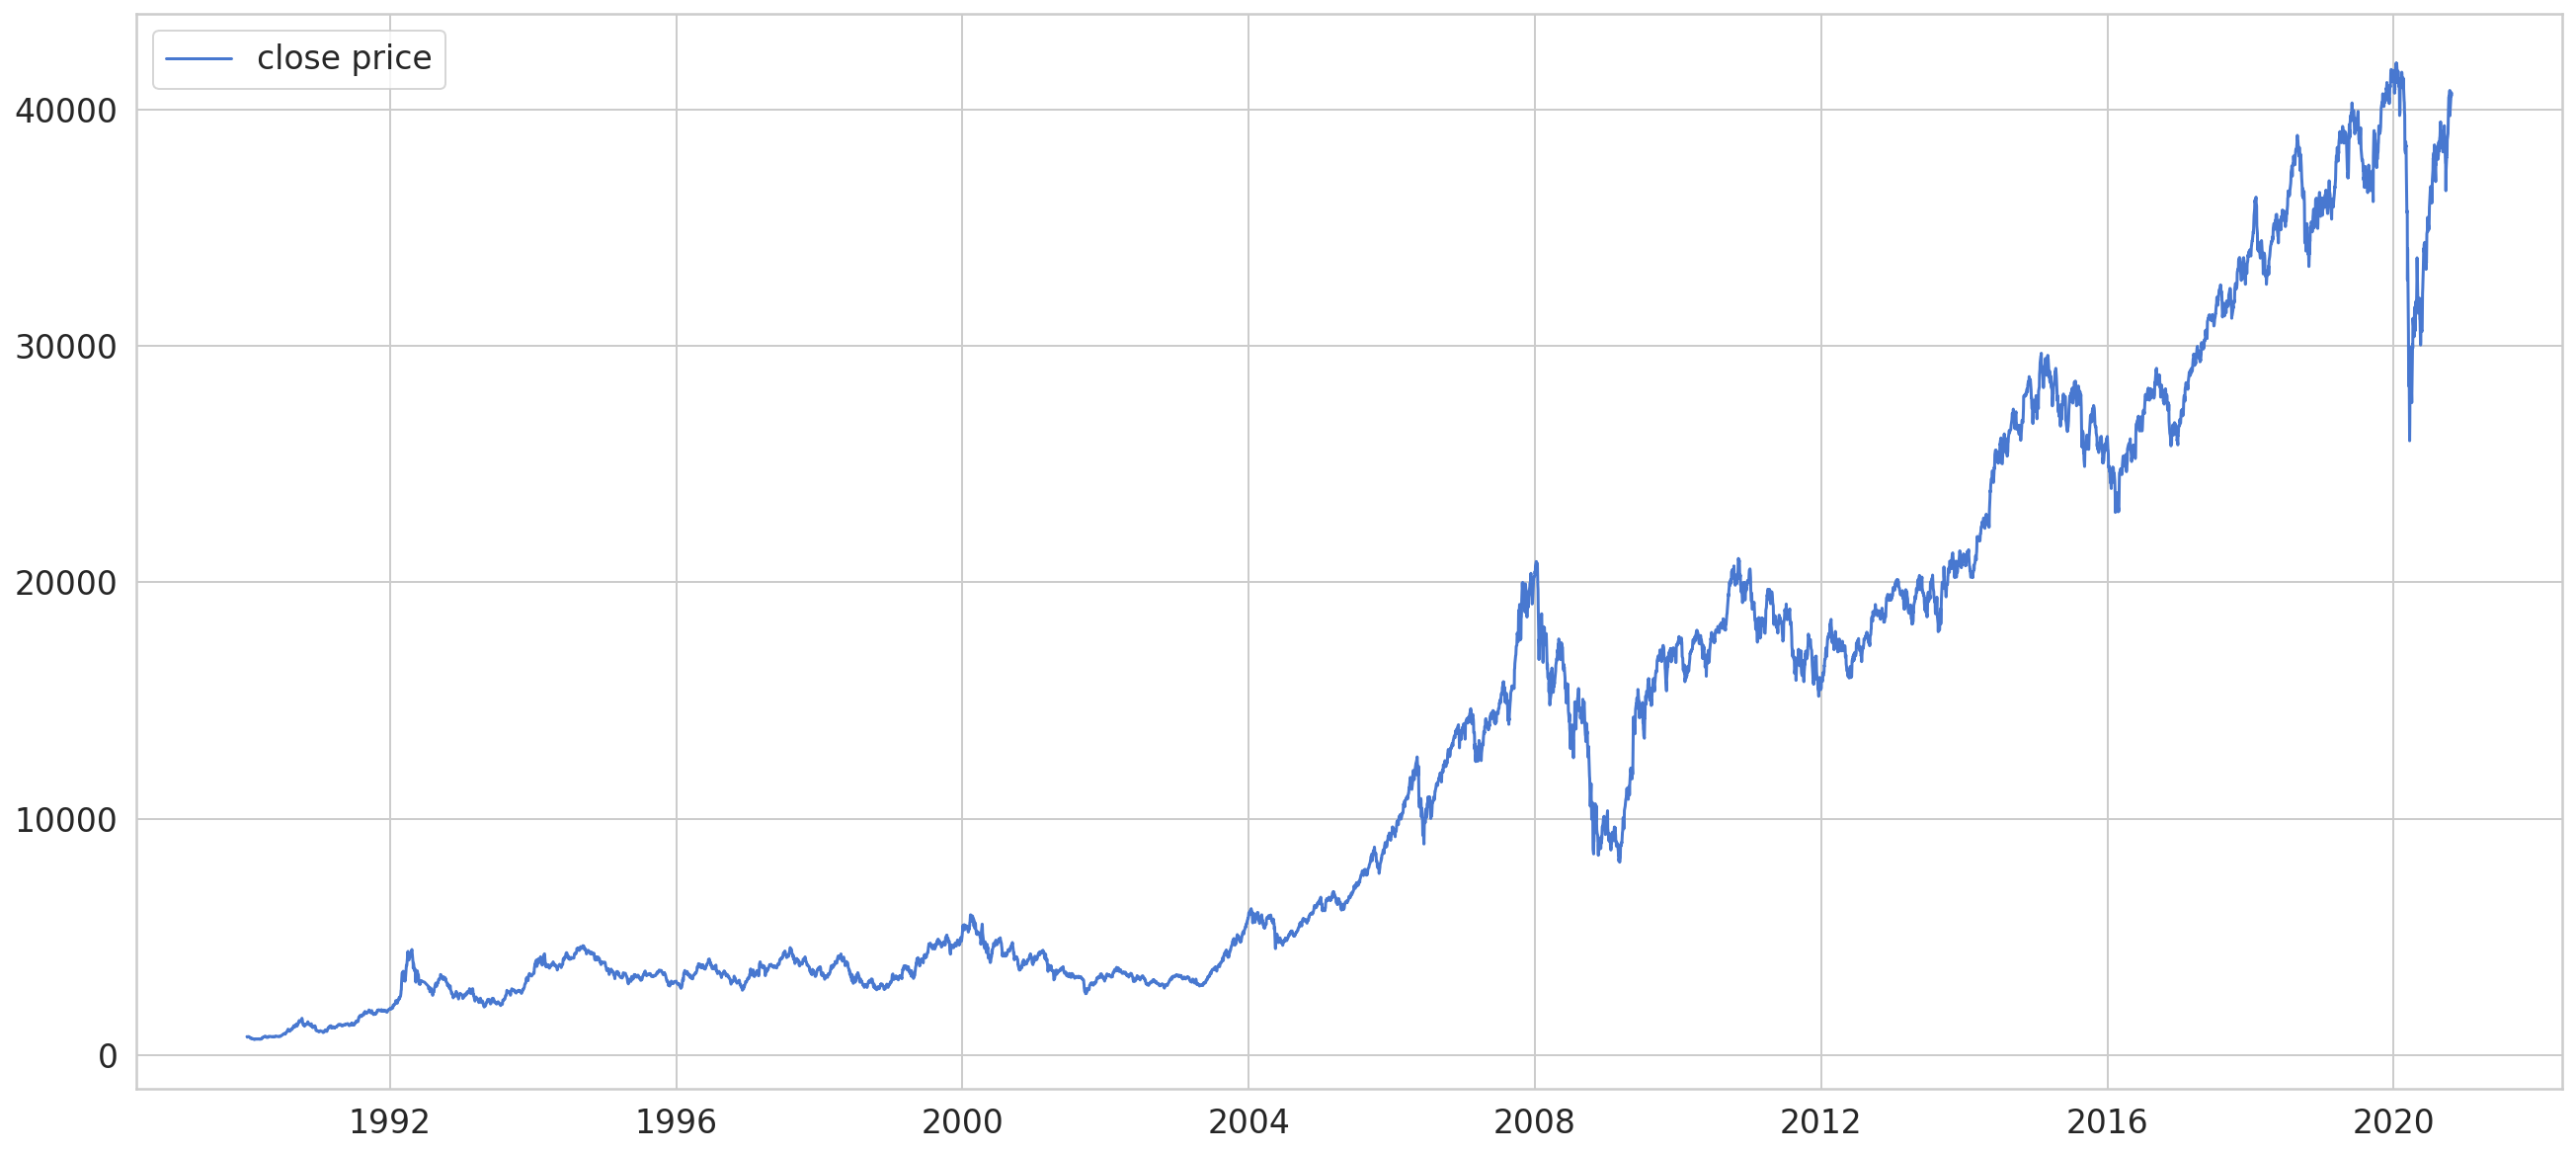

In [41]:
plt.plot(df, label='close price')
plt.legend();

## Data Preprocessing

In [43]:
train_size = int(len(df) * 0.90)
test_size = len(df) - train_size
train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
print(train.shape, test.shape)

(6682, 1) (743, 1)


In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler = scaler.fit(train[['close']])

train['close'] = scaler.transform(train[['close']])
test['close'] = scaler.transform(test[['close']])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


## Create Training and Test Splits

In [45]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)        
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [46]:
TIME_STEPS = 30

# reshape to [samples, time_steps, n_features]

X_train, y_train = create_dataset(train[['close']], train.close, TIME_STEPS)
X_test, y_test = create_dataset(test[['close']], test.close, TIME_STEPS)

print(X_train.shape)

(6652, 30, 1)


## Build an LSTM Autoencoder

In [47]:
model = keras.Sequential()
model.add(keras.layers.LSTM(
    units=64, 
    input_shape=(X_train.shape[1], X_train.shape[2])
))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.RepeatVector(n=X_train.shape[1]))
model.add(keras.layers.LSTM(units=64, return_sequences=True))
model.add(keras.layers.Dropout(rate=0.2))
model.add(keras.layers.TimeDistributed(keras.layers.Dense(units=X_train.shape[2])))
model.compile(loss='mae', optimizer='adam')

## Train the Autoencoder

In [48]:
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/10
42/42 [==============================] - 7s 90ms/step - loss: 0.3902 - val_loss: 0.2760
Epoch 2/10
42/42 [==============================] - 3s 73ms/step - loss: 0.1784 - val_loss: 0.3641
Epoch 3/10
42/42 [==============================] - 3s 72ms/step - loss: 0.1658 - val_loss: 0.2111
Epoch 4/10
42/42 [==============================] - 3s 72ms/step - loss: 0.1559 - val_loss: 0.2052
Epoch 5/10
42/42 [==============================] - 3s 71ms/step - loss: 0.1429 - val_loss: 0.1825
Epoch 6/10
42/42 [==============================] - 3s 72ms/step - loss: 0.1341 - val_loss: 0.1382
Epoch 7/10
42/42 [==============================] - 3s 71ms/step - loss: 0.1268 - val_loss: 0.1457
Epoch 8/10
42/42 [==============================] - 3s 71ms/step - loss: 0.1209 - val_loss: 0.1312
Epoch 9/10
42/42 [==============================] - 3s 72ms/step - loss: 0.1205 - val_loss: 0.1233
Epoch 10/10
42/42 [==============================] - 3s 71ms/step - loss: 0.1155 - val_loss: 0.1063


## Plot Metrics and Evaluate the Model

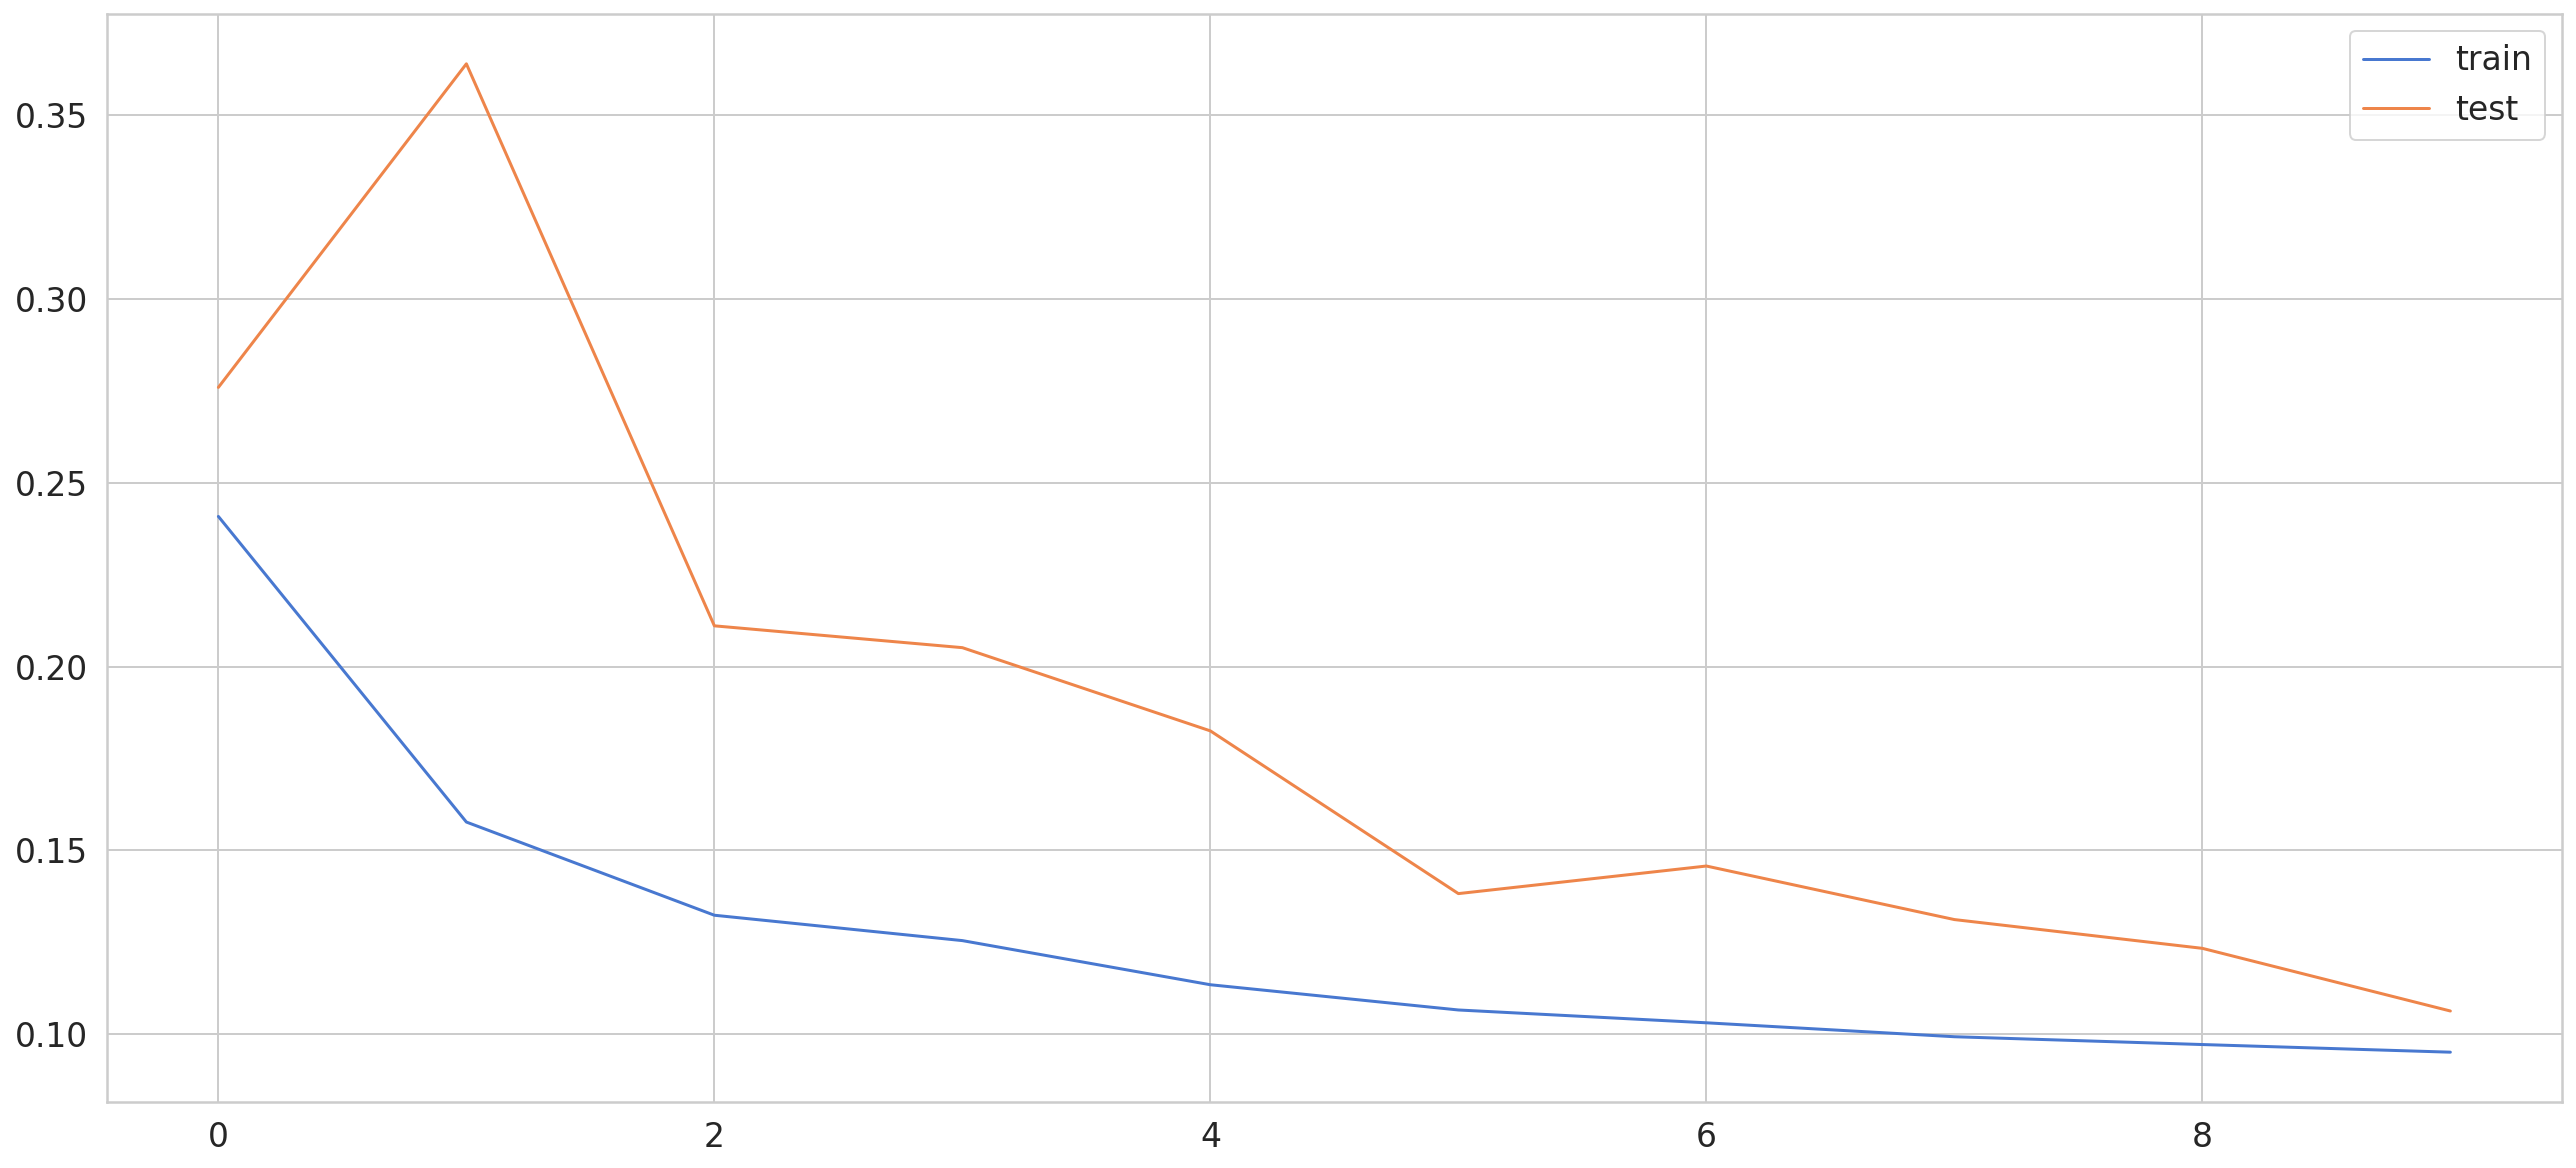

In [49]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend();

In [50]:
X_train_pred = model.predict(X_train)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


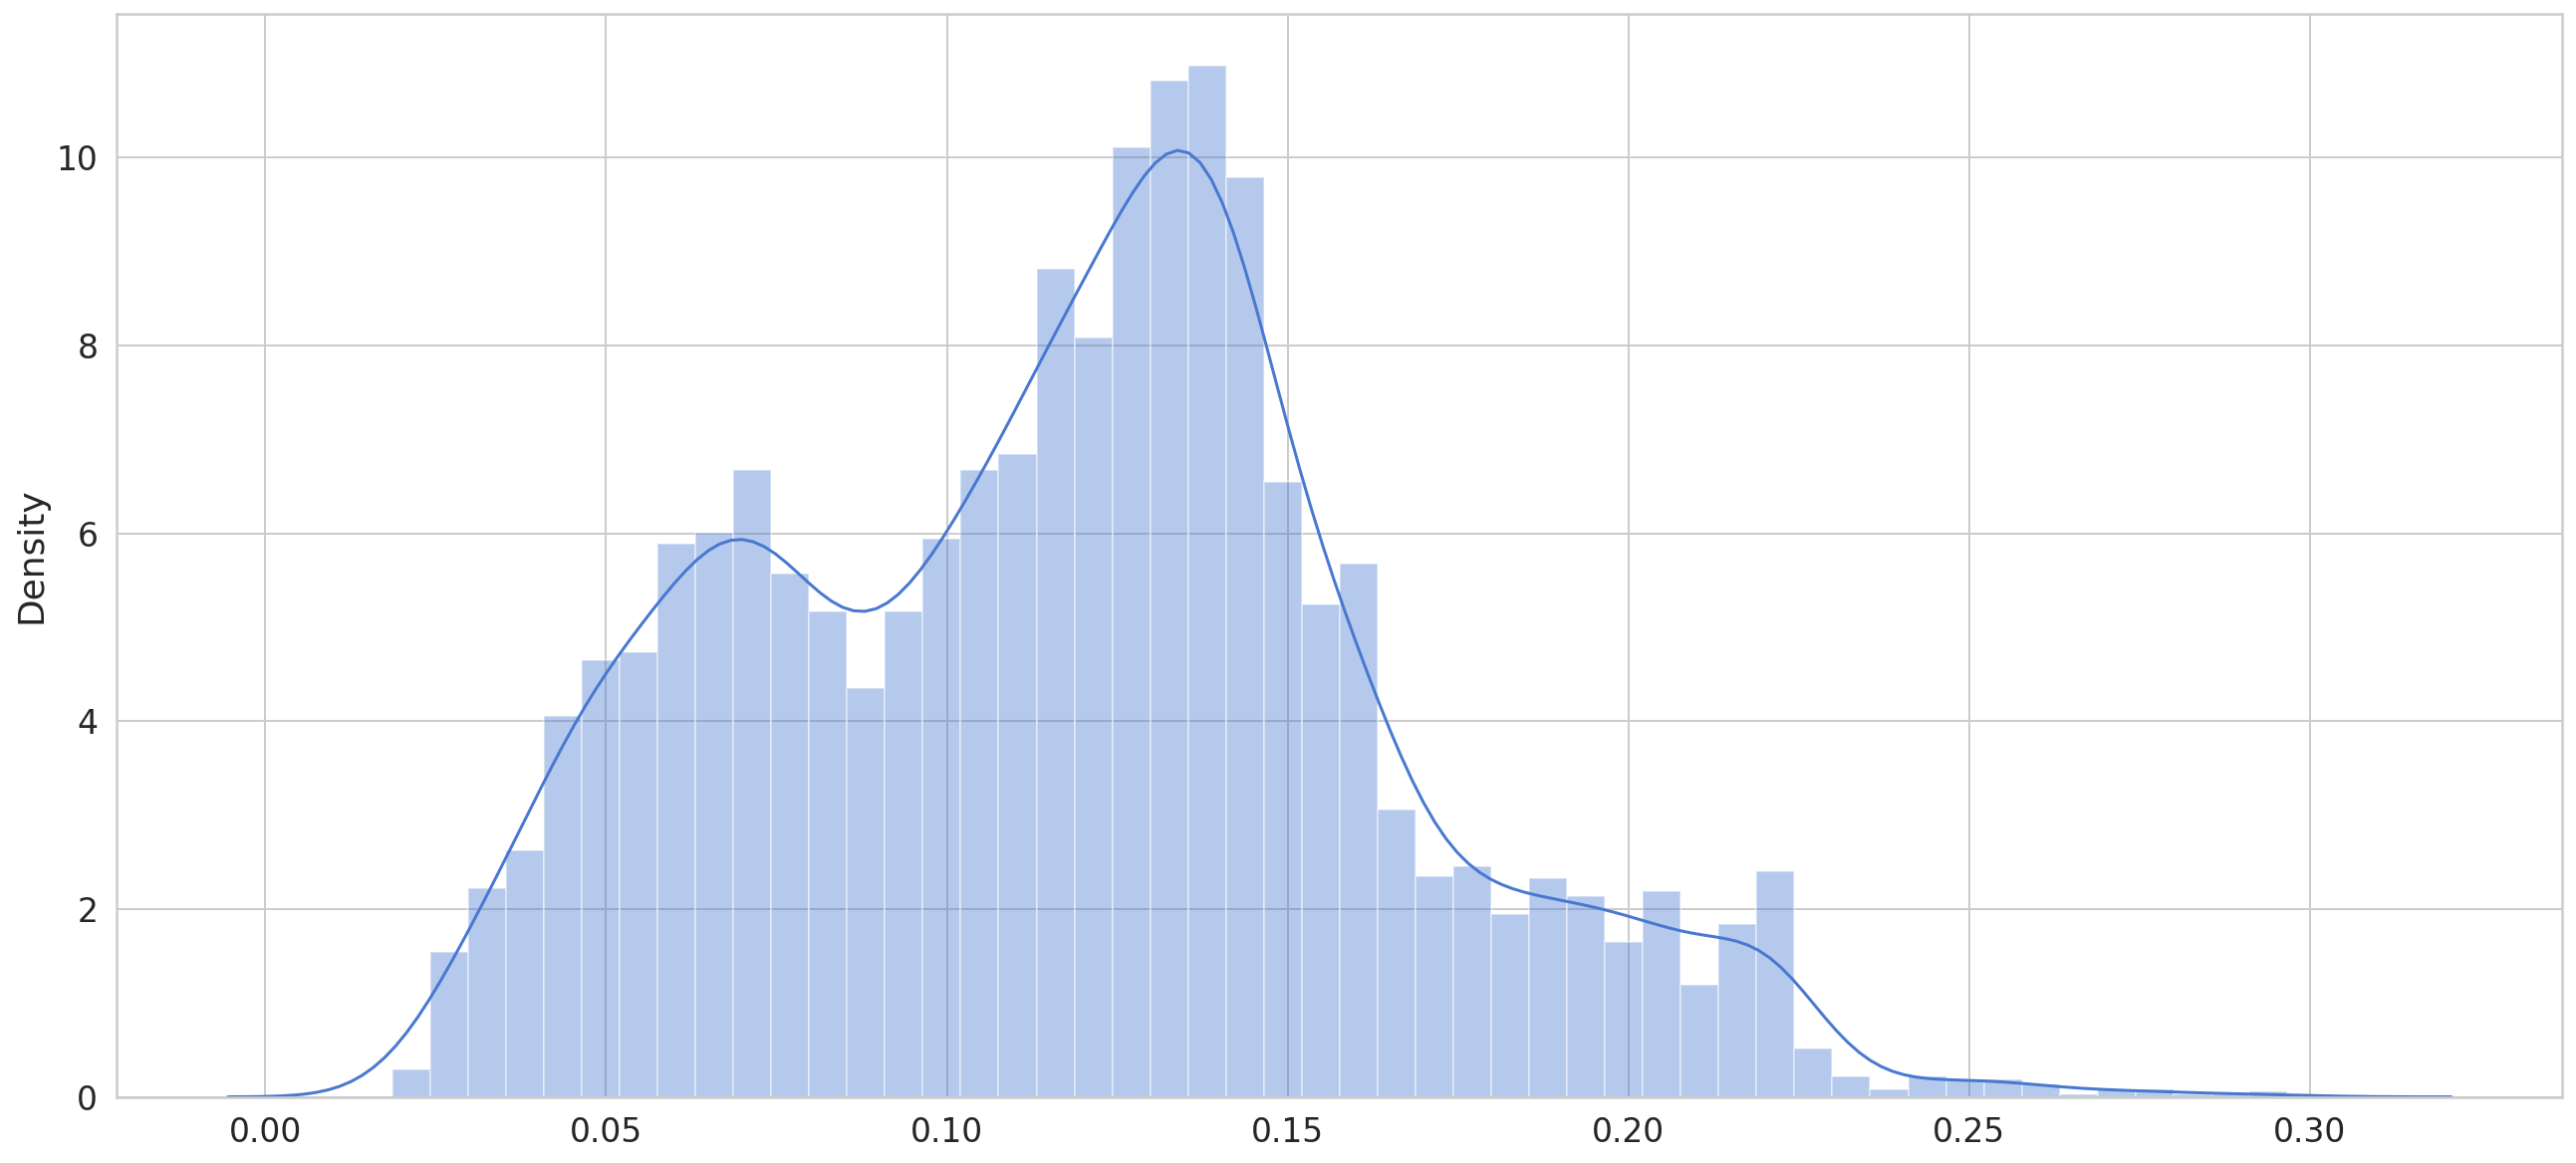

In [51]:
sns.distplot(train_mae_loss, bins=50, kde=True);

In [52]:
X_test_pred = model.predict(X_test)

test_mae_loss = np.mean(np.abs(X_test_pred - X_test), axis=1)


## Detect Anomalies in the SENSEX Index Data

In [53]:
THRESHOLD = 0.27

test_score_df = pd.DataFrame(index=test[TIME_STEPS:].index)
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = THRESHOLD
test_score_df['anomaly'] = test_score_df.loss > test_score_df.threshold
test_score_df['close'] = test[TIME_STEPS:].close

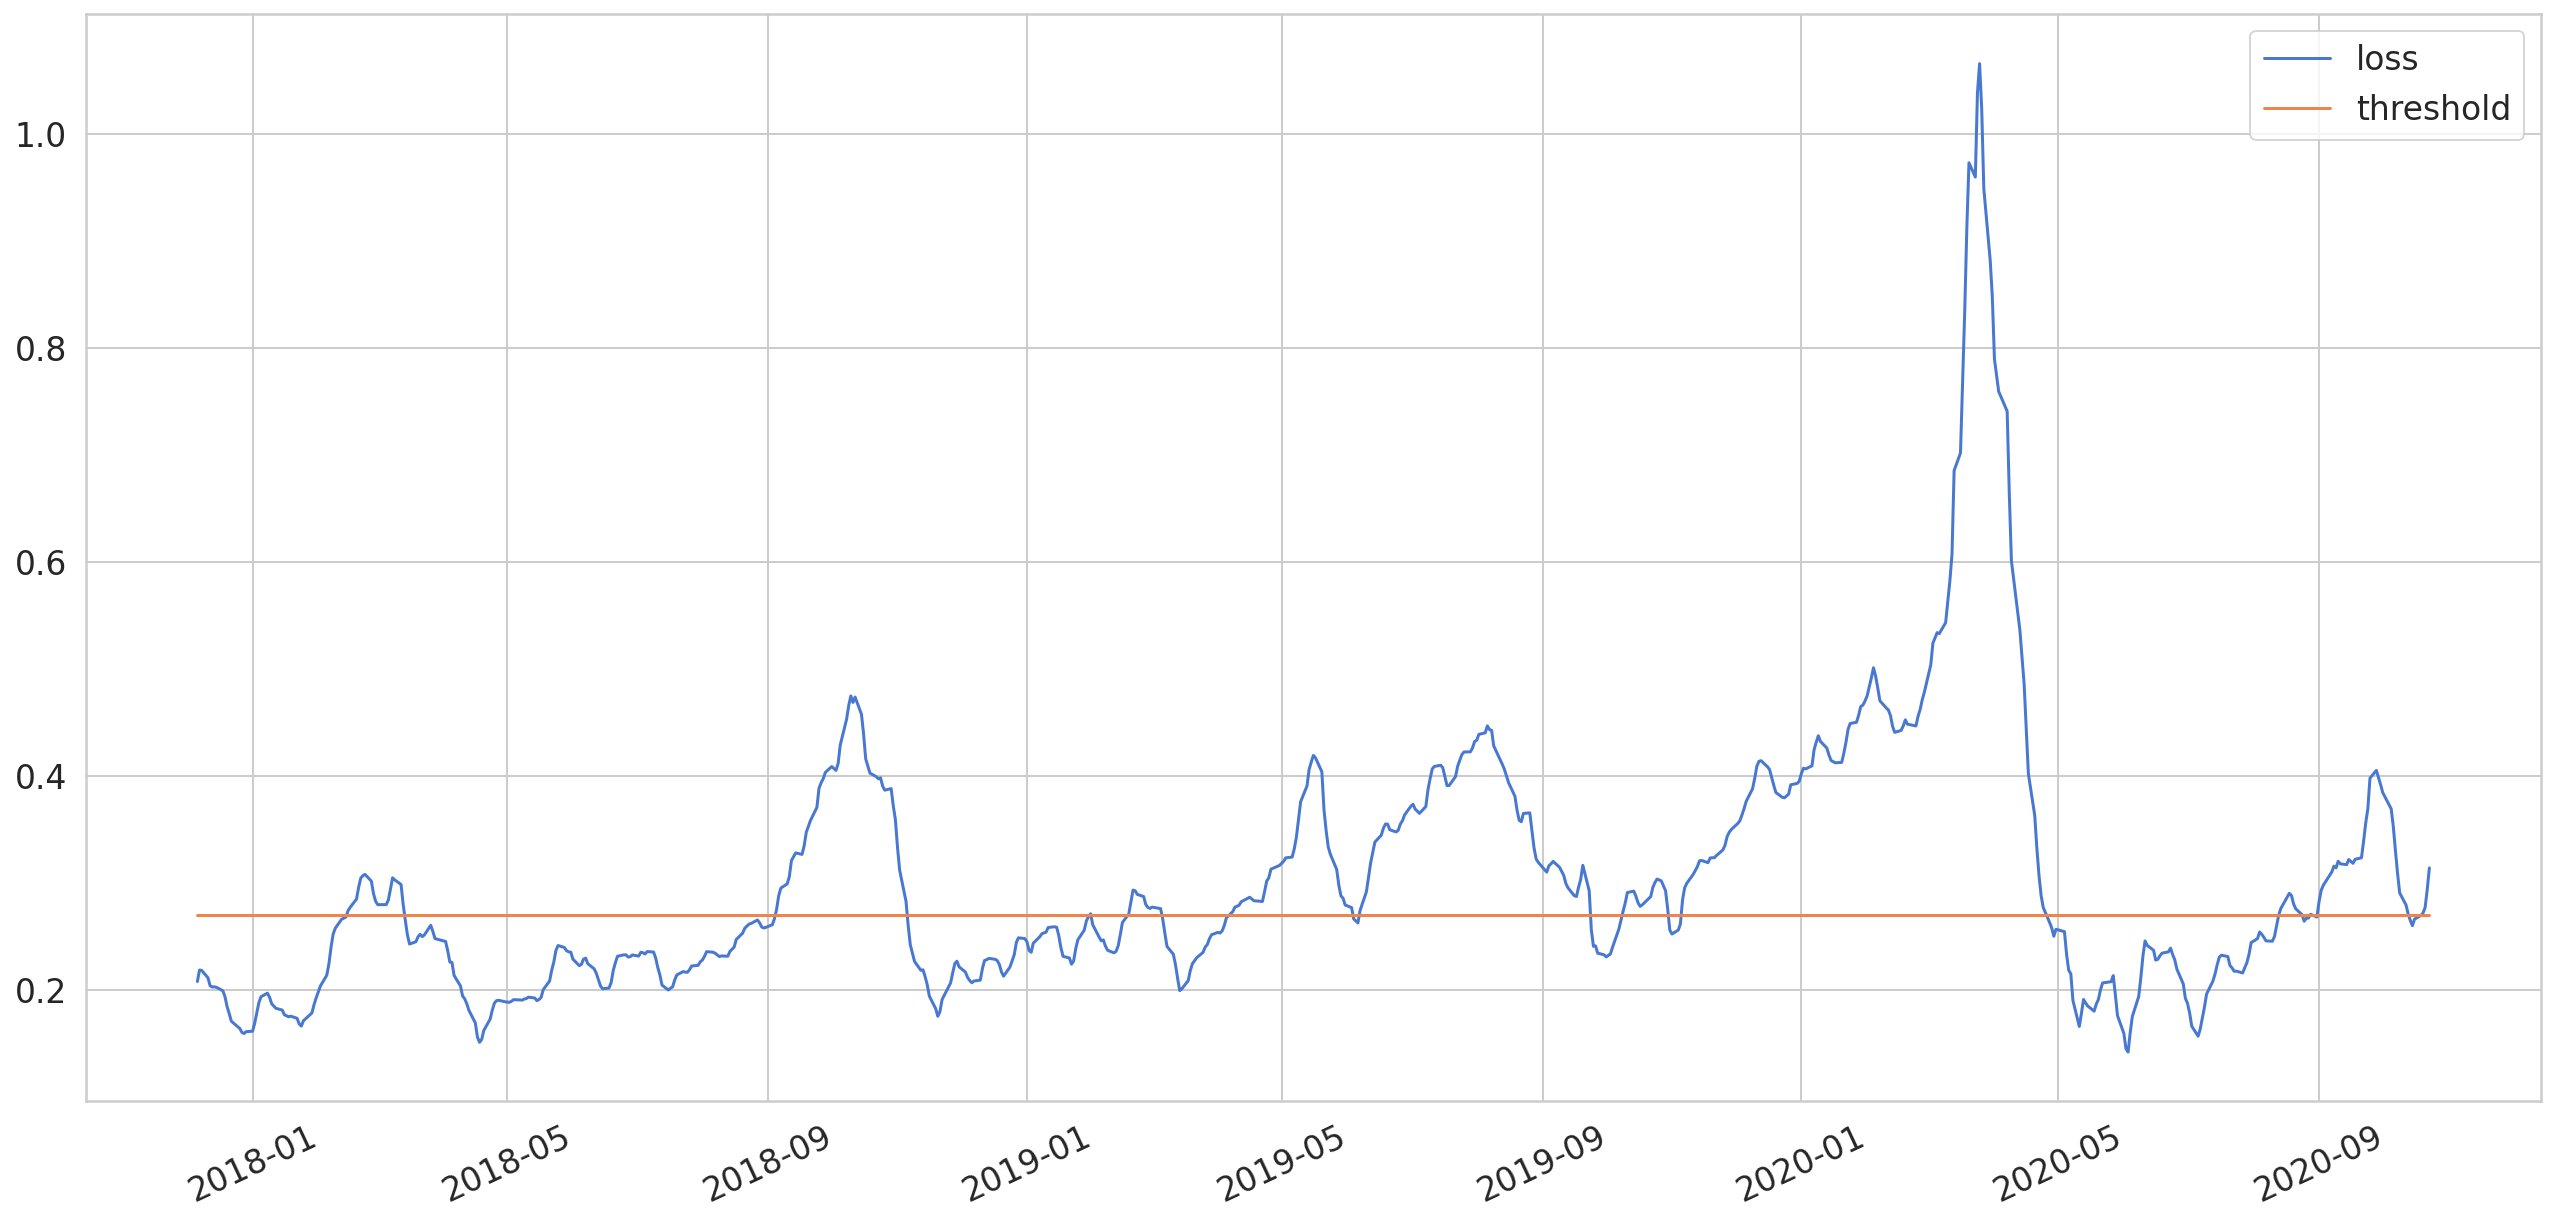

In [54]:
plt.plot(test_score_df.index, test_score_df.loss, label='loss')
plt.plot(test_score_df.index, test_score_df.threshold, label='threshold')
plt.xticks(rotation=25)
plt.legend();

In [55]:
anomalies = test_score_df[test_score_df.anomaly == True]
anomalies

,loss,threshold,anomaly,close
date,,,,
2018-02-15,0.274116,0.27,True,2.659168
2018-02-16,0.277280,0.27,True,2.626889
2018-02-19,0.285051,0.27,True,2.600308
2018-02-20,0.295975,0.27,True,2.592307
2018-02-21,0.304633,0.27,True,2.608212
...,...,...,...,...
2020-10-13,0.271043,0.27,True,3.371596
2020-10-20,0.271998,0.27,True,3.362461
2020-10-21,0.277228,0.27,True,3.380806


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


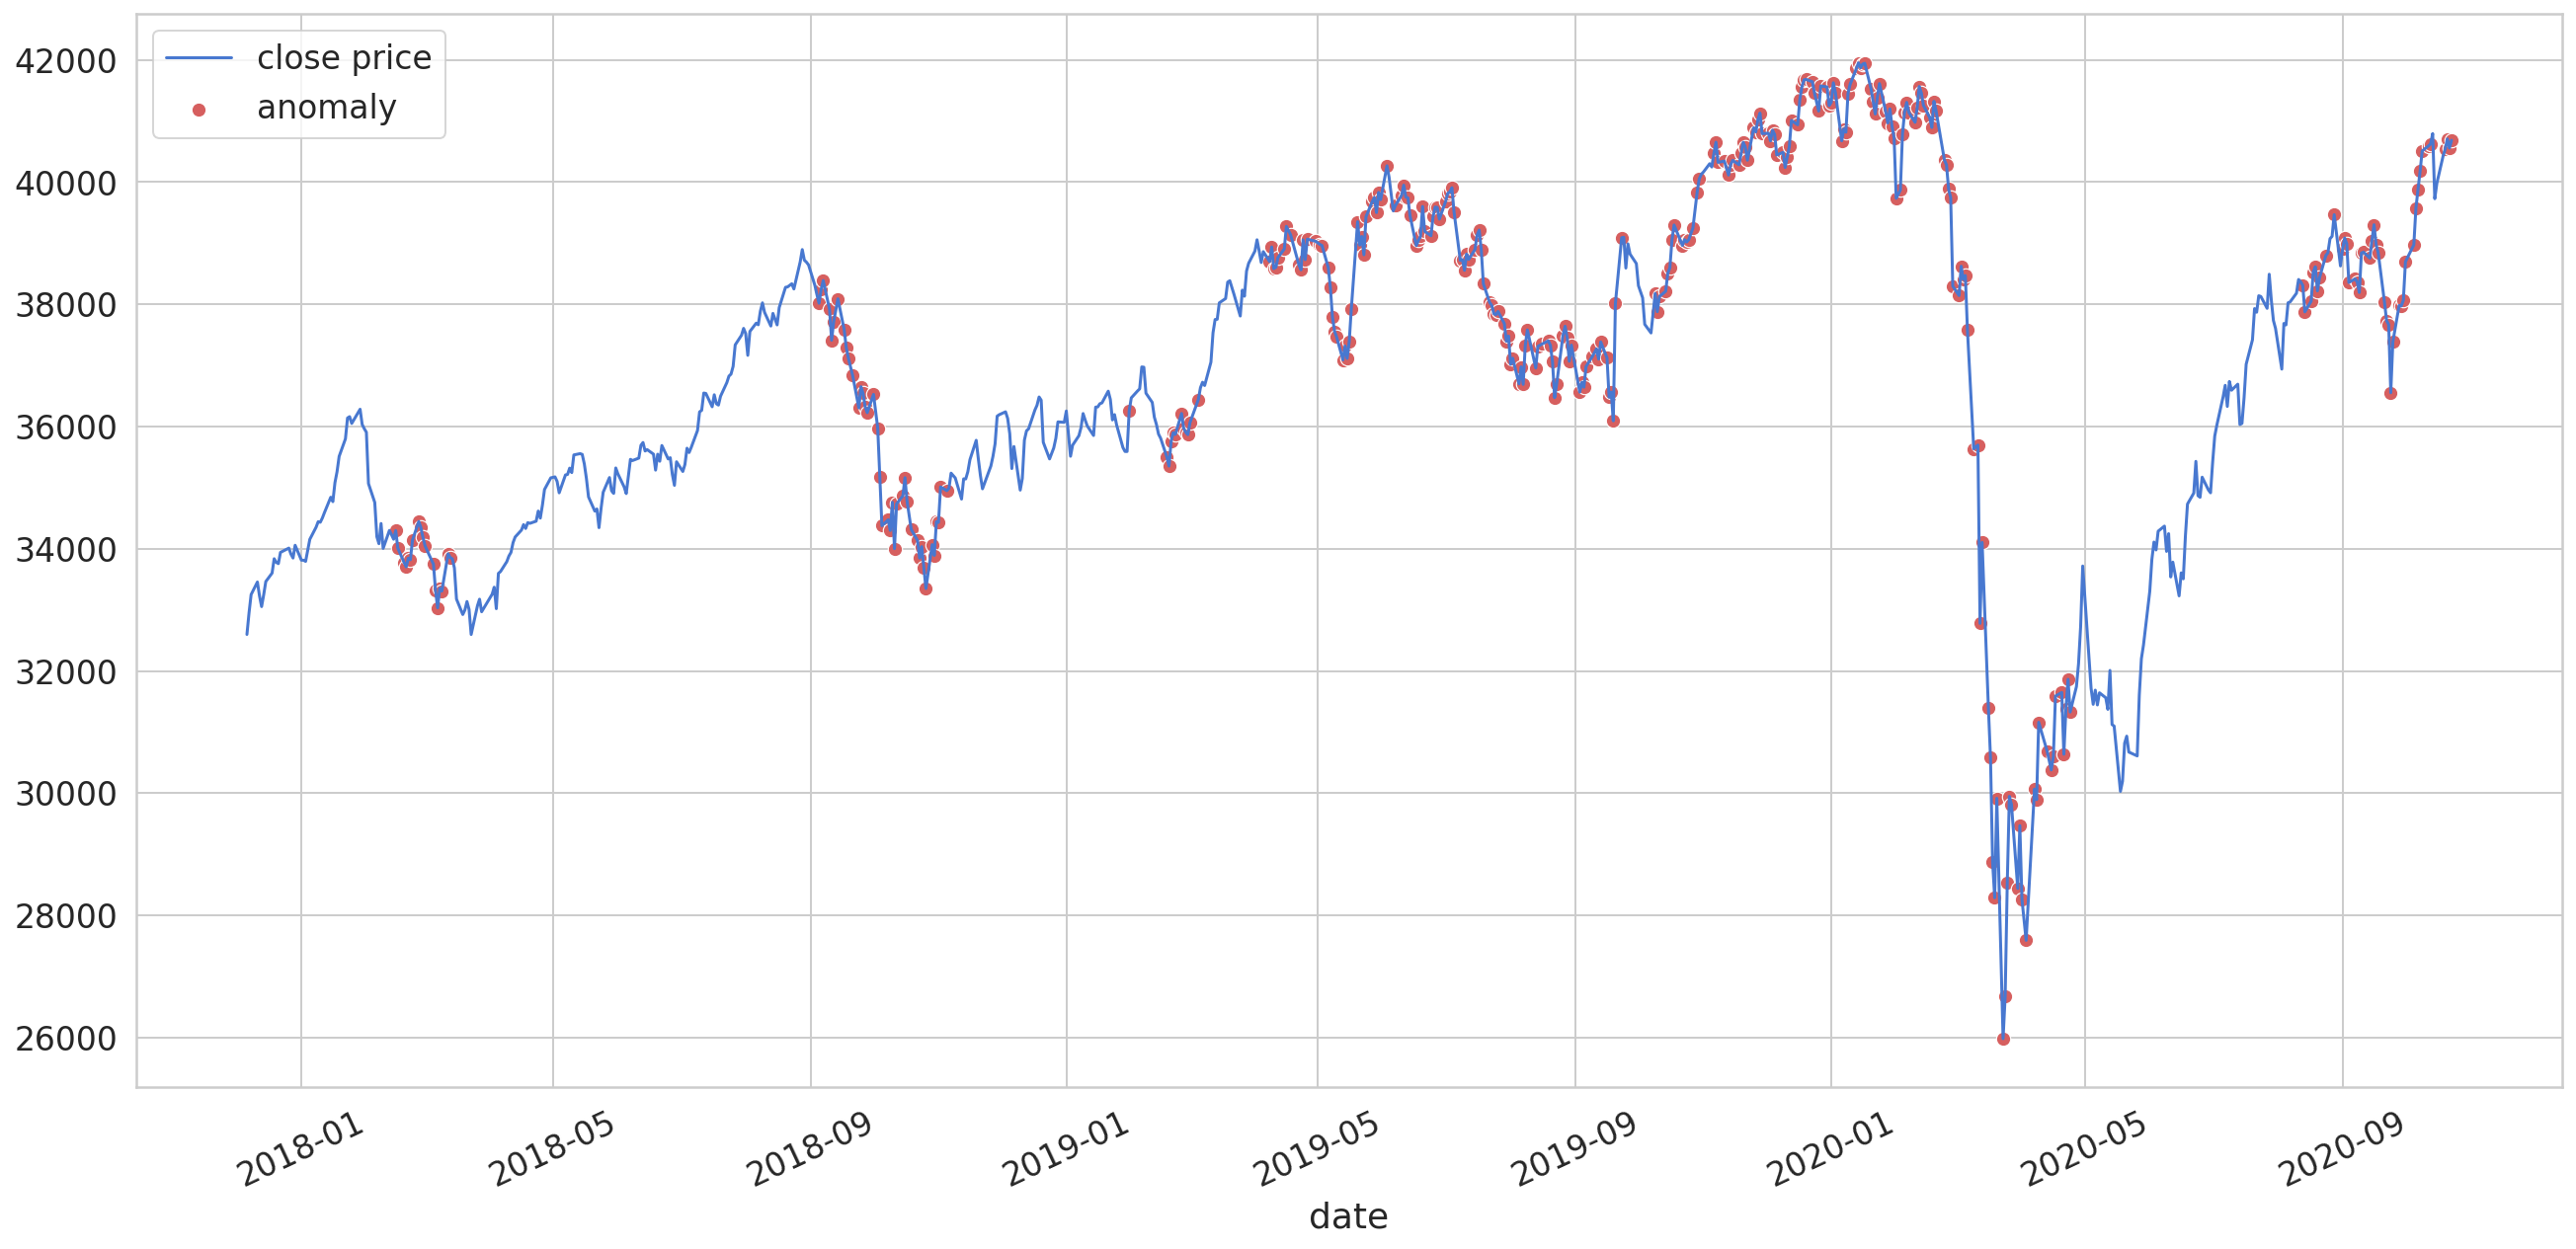

In [57]:
plt.plot(
  test[TIME_STEPS:].index, 
  scaler.inverse_transform(test[TIME_STEPS:].close), 
  label='close price'
);

sns.scatterplot(
  anomalies.index,
  scaler.inverse_transform(anomalies.close),
  color=sns.color_palette()[3],
  s=52,
  label='anomaly'
)
plt.xticks(rotation=25)
plt.legend();

In [63]:

import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x = test[TIME_STEPS:].index, y = scaler.inverse_transform(test[TIME_STEPS:].close),mode='lines',name='Close Price'))
fig.add_trace(go.Scatter(x = anomalies.index, y = scaler.inverse_transform(anomalies.close),mode='markers',name='Anomalies'))
fig.update_layout(showlegend = True)
fig.show()